In [1]:
!git clone https://github.com/facebookresearch/dino.git
%cd dino

# Install requirements
!pip install -r requirements.txt
!pip install torchvision torch

Cloning into 'dino'...
remote: Enumerating objects: 175, done.
remote: Total 175 (delta 0), reused 0 (delta 0), pack-reused 175 (from 1)
Receiving objects: 100% (175/175), 24.47 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (100/100), done.
/content/dino
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import random_split, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLIENTS = 100
C = 0.1
PARTICIPATING_CLIENTS = int(NUM_CLIENTS * C)
NUM_ROUNDS = 100
LOCAL_EPOCHS = 4
BATCH_SIZE = 32
USE_NON_IID = True
CLASSES_PER_CLIENT = 2


transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                              download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                             download=True, transform=transform)

train_set, val_set = random_split(train_dataset, [40000, 10000])
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


In [3]:
def split_dataset(dataset, num_clients, non_iid=False, classes_per_client=2):
    if not non_iid:
        size_per_client = len(dataset) // num_clients
        return random_split(dataset, [size_per_client]*num_clients)

    from collections import defaultdict
    import random

    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    client_indices = [[] for _ in range(num_clients)]
    all_classes = list(class_indices.keys())

    for client_id in range(num_clients):
        chosen_classes = random.sample(all_classes, classes_per_client)
        for c in chosen_classes:
            take_n = len(class_indices[c]) // num_clients
            client_indices[client_id].extend(class_indices[c][:take_n])
            class_indices[c] = class_indices[c][take_n:]

    return [torch.utils.data.Subset(dataset, idxs) for idxs in client_indices]

client_datasets = split_dataset(train_set, NUM_CLIENTS, non_iid=USE_NON_IID, classes_per_client=CLASSES_PER_CLIENT)
client_loaders = [DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True) for ds in client_datasets]

In [4]:
from collections import Counter

def get_client_class_distribution(datasets, num_clients_to_show=10):
    print(f"Showing class distribution for {num_clients_to_show} clients:\n")
    for i in range(num_clients_to_show):
        labels = [label for _, label in datasets[i]]
        label_counts = Counter(labels)
        print(f"Client {i} has classes: {sorted(label_counts.items())}")

get_client_class_distribution(client_datasets)

Showing class distribution for 10 clients:

Client 0 has classes: [(2, 4), (39, 3)]
Client 1 has classes: [(30, 4), (60, 4)]
Client 2 has classes: [(84, 4), (90, 4)]
Client 3 has classes: [(26, 3), (45, 3)]
Client 4 has classes: [(1, 4), (15, 3)]
Client 5 has classes: [(19, 3), (97, 4)]
Client 6 has classes: [(56, 3), (86, 4)]
Client 7 has classes: [(44, 3), (97, 4)]
Client 8 has classes: [(8, 3), (43, 3)]
Client 9 has classes: [(32, 3), (88, 4)]


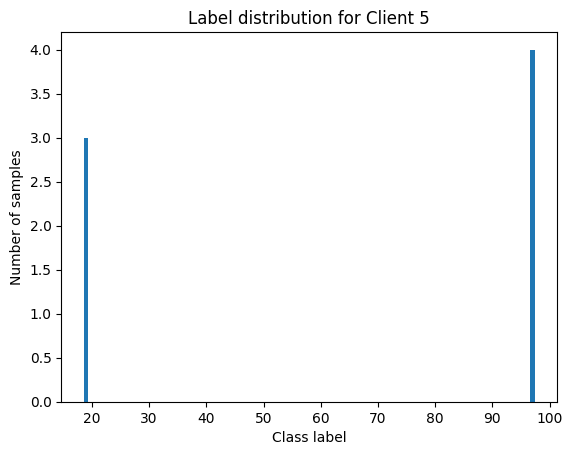

In [5]:
import matplotlib.pyplot as plt

def plot_client_label_histogram(client_id):
    labels = [label for _, label in client_datasets[client_id]]
    counts = Counter(labels)
    plt.bar(counts.keys(), counts.values())
    plt.title(f"Label distribution for Client {client_id}")
    plt.xlabel("Class label")
    plt.ylabel("Number of samples")
    plt.show()

plot_client_label_histogram(5)

In [6]:
import vision_transformer as vits

def get_fresh_model():
    model = vits.__dict__['vit_small'](patch_size=16)
    state_dict = torch.hub.load_state_dict_from_url(
        "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth",
        map_location=device
    )
    model.load_state_dict(state_dict, strict=True)
    classifier = nn.Linear(model.embed_dim, 100)
    return model.to(device), classifier.to(device)

global_model, global_classifier = get_fresh_model()

Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 221MB/s]


In [7]:
def train_local(model, classifier, dataloader, epochs, device, grad_mask=None):
    model.train()
    classifier.train()
    optimizer = torch.optim.SGD(
        list(model.parameters()) + list(classifier.parameters()),
        lr=0.001, momentum=0.9
    )
    criterion = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            features = model(images)

            if isinstance(features, dict) and 'x_norm_clstoken' in features:
                features = features['x_norm_clstoken']
            elif features.ndim == 3:
                features = features[:, 0, :]

            outputs = classifier(features)
            loss = criterion(outputs, labels)
            loss.backward()

            if grad_mask:
                for name, param in model.named_parameters():
                    if name in grad_mask and param.grad is not None:
                        param.grad *= grad_mask[name].to(param.device)
                for name, param in classifier.named_parameters():
                    full_name = f"classifier.{name}"
                    if full_name in grad_mask and param.grad is not None:
                        param.grad *= grad_mask[full_name].to(param.device)
            optimizer.step()

    return model.state_dict(), classifier.state_dict()


def generate_random_mask(model, classifier, sparsity=0.7):
    mask = {}
    for name, param in model.named_parameters():
        mask[name] = torch.bernoulli(torch.full_like(param, 1 - sparsity))
    for name, param in classifier.named_parameters():
        full_name = f"classifier.{name}"
        mask[full_name] = torch.bernoulli(torch.full_like(param, 1 - sparsity))
    return mask

def average_weights(weight_list):
    avg = weight_list[0].copy()
    for key in avg:
        for i in range(1, len(weight_list)):
            avg[key] += weight_list[i][key]
        avg[key] = avg[key] / len(weight_list)
    return avg

def evaluate(model, classifier, loader):
    model.eval()
    classifier.eval()
    correct, total = 0, 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            feats = model(images)
            preds = classifier(feats)
            loss = criterion(preds, labels)
            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(preds, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    avg_loss = total_loss / total
    return acc, avg_loss

def evaluate_test(model, classifier, loader):
    return evaluate(model, classifier, loader)


In [ ]:
import random
import time
import csv
import copy

val_accuracies = []
val_losses = []
start_time = time.time()

for round_idx in range(NUM_ROUNDS):
    print(f"--- Round {round_idx + 1} ---")
    local_model_weights, local_clf_weights = [], []

    selected_clients_indices = random.sample(range(NUM_CLIENTS), PARTICIPATING_CLIENTS)

    for i in selected_clients_indices:
        client_model = copy.deepcopy(global_model)
        client_clf = copy.deepcopy(global_classifier)

        grad_mask = generate_random_mask(client_model, client_clf, sparsity=0.7)

        mw, cw = train_local(
            client_model, client_clf, client_loaders[i],
            LOCAL_EPOCHS, device, grad_mask=grad_mask
        )
        local_model_weights.append(mw)
        local_clf_weights.append(cw)

        del client_model, client_clf
        torch.cuda.empty_cache()

    global_model.load_state_dict(average_weights(local_model_weights))
    global_classifier.load_state_dict(average_weights(local_clf_weights))

    acc, loss = evaluate(global_model, global_classifier, val_loader)
    val_accuracies.append(acc)
    val_losses.append(loss)
    print(f"Validation Accuracy: {acc:.2f}%, Validation Loss: {loss:.4f}")

print("\nFederated IID Training with RANDOM MASK Complete!")
print(f"Total training time: {(time.time() - start_time)/60:.2f} minutes")

test_acc, test_loss = evaluate(global_model, global_classifier, test_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

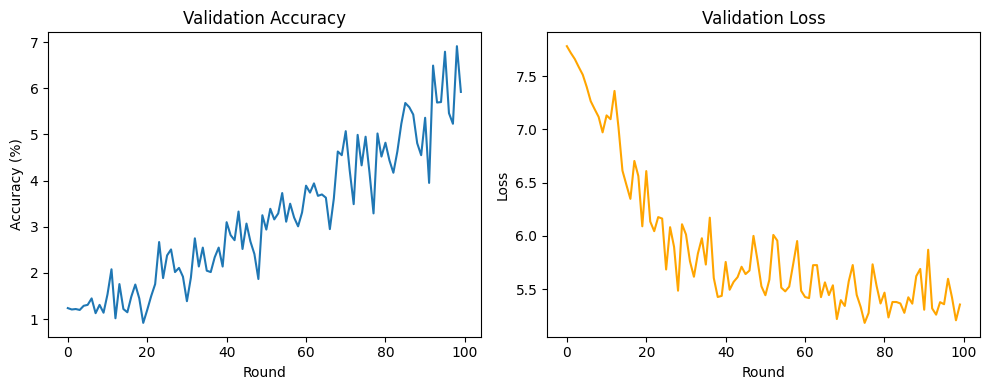

In [15]:
import json
import os

EXPERIMENT_NAME = "non_iid_j4X_with_sensative_mask"
SAVE_DIR = "results_j4X_with_sensative_mask"
os.makedirs(SAVE_DIR, exist_ok=True)


with open(f"{SAVE_DIR}/val_accuracy_{EXPERIMENT_NAME}.json", "w") as f:
    json.dump(val_accuracies, f)

with open(f"{SAVE_DIR}/val_loss_{EXPERIMENT_NAME}.json", "w") as f:
    json.dump(val_losses, f)

with open(f"{SAVE_DIR}/final_test_accuracy_{EXPERIMENT_NAME}.txt", "w") as f:
    f.write(str(test_acc))

with open(f"{SAVE_DIR}/final_test_loss_{EXPERIMENT_NAME}.txt", "w") as f:
    f.write(str(test_loss))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(val_losses, label="Val Loss", color="orange")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Validation Loss")

plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/val_accuracy_loss_plot_{EXPERIMENT_NAME}.png")
plt.show()

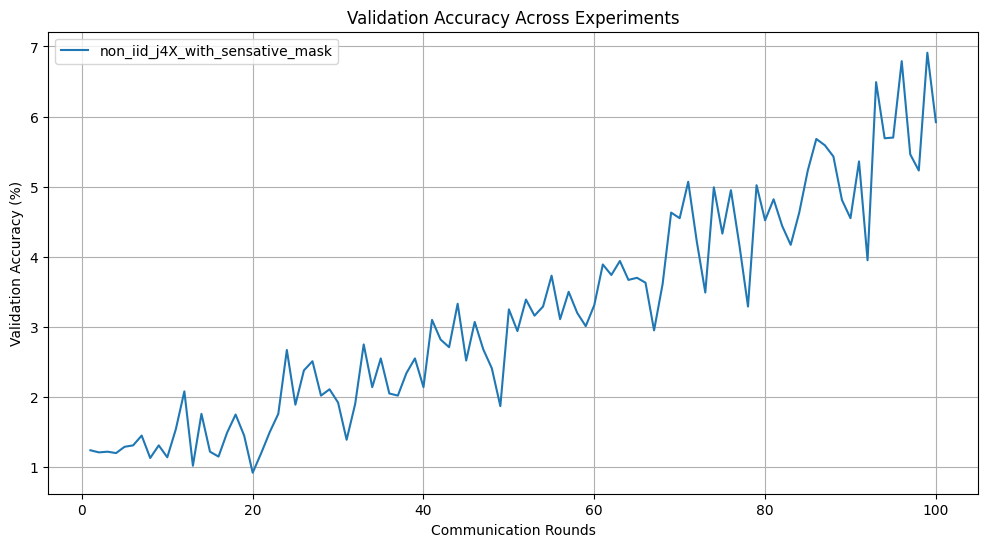


=== Final Test Accuracy Summary ===
non_iid_j4X_with_sensative_mask: 6.31%


In [16]:
import os
import json
import matplotlib.pyplot as plt

result_dir = "results_j4X_with_sensative_mask"
val_accuracies_dict = {}
test_accuracies_dict = {}

for fname in os.listdir(result_dir):
    if fname.startswith("val_accuracy") and fname.endswith(".json"):
        label = fname.replace("val_accuracy_", "").replace(".json", "")
        with open(os.path.join(result_dir, fname), "r") as f:
            val_accuracies_dict[label] = json.load(f)
    if fname.startswith("final_test_accuracy") and fname.endswith(".txt"):
        label = fname.replace("final_test_accuracy_", "").replace(".txt", "")
        with open(os.path.join(result_dir, fname), "r") as f:
            test_accuracies_dict[label] = float(f.read().strip())

plt.figure(figsize=(12, 6))
for label, accs in val_accuracies_dict.items():
    plt.plot(range(1, len(accs)+1), accs, label=label)
plt.xlabel("Communication Rounds")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Across Experiments")
plt.legend()
plt.grid(True)
plt.savefig("results_j4X_with_sensative_mask/comparison_plot.png")
plt.show()

print("\n=== Final Test Accuracy Summary ===")
for label, acc in sorted(test_accuracies_dict.items()):
    print(f"{label}: {acc:.2f}%")

In [17]:
from google.colab import files

!zip -r results_j4X_with_sensative_mask.zip results_j4X_with_sensative_mask/

files.download('results_j4X_with_sensative_mask.zip')

  adding: results_j4X_with_sensative_mask/ (stored 0%)
  adding: results_j4X_with_sensative_mask/val_accuracy_loss_plot_non_iid_j4X_with_sensative_mask.png (deflated 4%)
  adding: results_j4X_with_sensative_mask/val_loss_non_iid_j4X_with_sensative_mask.json (deflated 52%)
  adding: results_j4X_with_sensative_mask/comparison_plot.png (deflated 8%)
  adding: results_j4X_with_sensative_mask/final_test_loss_non_iid_j4X_with_sensative_mask.txt (stored 0%)
  adding: results_j4X_with_sensative_mask/final_test_accuracy_non_iid_j4X_with_sensative_mask.txt (stored 0%)
  adding: results_j4X_with_sensative_mask/val_accuracy_non_iid_j4X_with_sensative_mask.json (deflated 64%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
with open("results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Round", "Validation Accuracy"])
    for i, acc in enumerate(val_accuracies, start=1):
        writer.writerow([i, acc])

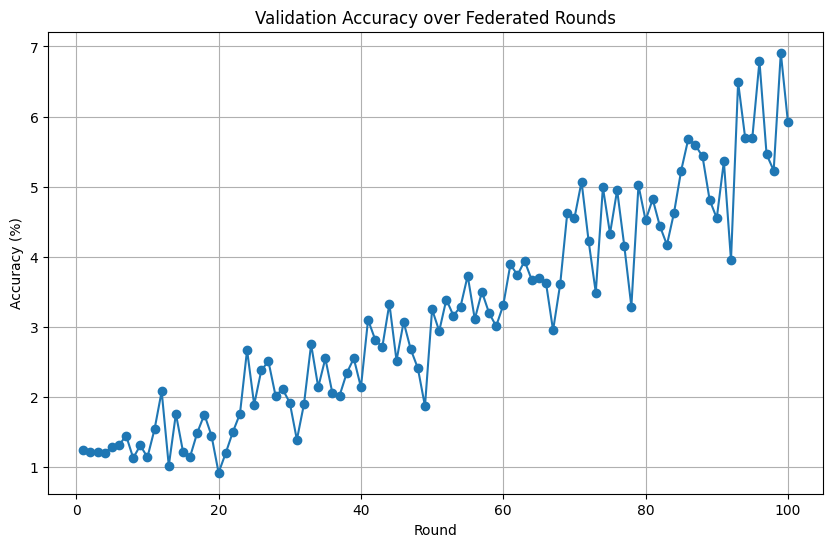

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_ROUNDS+1), val_accuracies, marker='o')
plt.title("Validation Accuracy over Federated Rounds")
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.savefig("val_accuracy_curve.png")
plt.show()

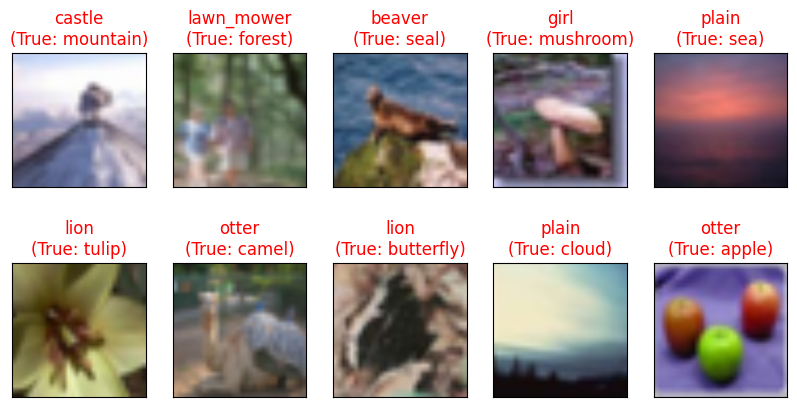

In [20]:
import matplotlib.pyplot as plt
import numpy as np

classes = train_dataset.classes

global_model.eval()
global_classifier.eval()

dataiter = iter(test_loader)
images, labels = next(dataiter)

images, labels = images.to(device), labels.to(device)
features = global_model(images)
outputs = global_classifier(features)
_, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(10, 5))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = images[idx].cpu().numpy().transpose((1, 2, 0))
    img = np.clip((img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406], 0, 1)
    plt.imshow(img)
    ax.set_title(f"{classes[predicted[idx]]}\n(True: {classes[labels[idx]]})",
                 color=("green" if predicted[idx]==labels[idx] else "red"))
plt.show()